## Proyecto 2 - Modelización

Desarrollado por David Gutiérrez & Natalia Núñez

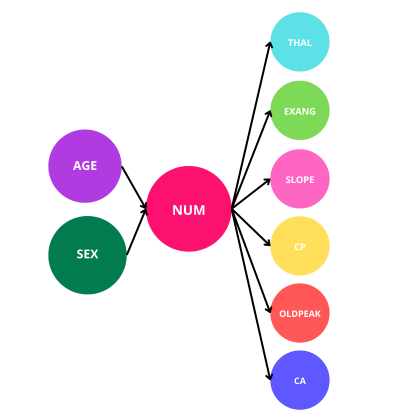

In [2]:
#Librerías
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

from pgmpy.inference import VariableElimination


C:\Users\JUAN JOSE F ROMERO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Importamos los datos como dataframe
columnas = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv('processed.cleveland_repaired.csv')

In [4]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.000000,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.000000,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.000000,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.000000,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.000000,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.000000,7.0,1.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.000000,7.0,2.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.000000,7.0,3.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.000000,3.0,1.0


In [4]:
#Convertimos datos a números

#En donde tengamos datos faltantes (?) ponemos 0

for column in df.columns:
    # Reemplazar valores "?" con 0 en la columna y fila respectivas
    df[column] = df[column].replace('?', 0)

df = df.apply(pd.to_numeric, errors='coerce')    

#print(df['age'].describe())# Valor máximo 77
#print(df['oldpeak'].describe())

Discretizar variables

In [5]:
#La variable age tiene que ser discreta para la red bayesiana, por lo que la dividiremos por cuartiles siendo 29 la edad minima y 77 la edad maxima 
df['age_discreta'] = df['age']
df.loc[df['age_discreta'] < (df['age_discreta'].describe()['25%']), 'age'] = 1
df.loc[((df['age_discreta'].describe()['25%']) <= df['age_discreta']) & (df['age_discreta'] < (df['age_discreta'].describe()['50%'])), 'age'] = 2
df.loc[((df['age_discreta'].describe()['50%']) <= df['age_discreta']) & (df['age_discreta'] < (df['age_discreta'].describe()['75%'])), 'age'] = 3
df.loc[((df['age_discreta'].describe()['75%']) <= df['age_discreta']) & (df['age_discreta'] < 77), 'age'] = 4
df.age = df.age.astype(int)

#La variable oldpeak tiene que ser discreta, por lo que la dividiremos por cuartiles siendo 0 el cuartil minimo y 6.2 el cuartil maximo
df['oldpeak_discreta'] = df['oldpeak']

df.loc[df['oldpeak_discreta'] < 0.8, 'oldpeak' ] = 1
df.loc[(0.8 <= df['oldpeak_discreta']) & (df['oldpeak_discreta'] < 1.6), 'oldpeak'] = 2
df.loc[(1.6 <= df['oldpeak_discreta']) & (df['oldpeak_discreta'] < 6.2), 'oldpeak'] = 3

df.oldpeak = df.oldpeak.astype(int)

#Variable num
df.loc[(df['num'] == 0) , 'num_discreta'] = 0
df.loc[(df['num'] != 0) , 'num_discreta'] = 1
df.num = df.num.astype(int)

#Eliminamos columnas sobrantes
df.drop(['num', 'age_discreta', 'oldpeak_discreta'], axis=1, inplace=True)
#df


Red Bayesiana

In [6]:
#Creamos modelo
model = BayesianNetwork(
    [ ("age","num_discreta"),
     ("sex","num_discreta"),
     ("num_discreta","thal"),
     ("num_discreta","exang"),
     ("num_discreta","slope"),
     ("num_discreta","cp"),
     ("num_discreta","oldpeak"),
     ("num_discreta","ca"),

    ]

)


Maximum Likelihood

In [9]:
model.fit(
    data=df,
    estimator=MaximumLikelihoodEstimator
)
for i in model.nodes():
    print(i)
    print(model.get_cpds(i))

age
+---------+------------+
| age(1)  | 0.249169   |
+---------+------------+
| age(2)  | 0.245847   |
+---------+------------+
| age(3)  | 0.242525   |
+---------+------------+
| age(4)  | 0.259136   |
+---------+------------+
| age(77) | 0.00332226 |
+---------+------------+
num_discreta
+-------------------+-----+----------+----------+
| age               | ... | age(77)  | age(77)  |
+-------------------+-----+----------+----------+
| sex               | ... | sex(0.0) | sex(1.0) |
+-------------------+-----+----------+----------+
| num_discreta(0.0) | ... | 0.5      | 0.0      |
+-------------------+-----+----------+----------+
| num_discreta(1.0) | ... | 0.5      | 1.0      |
+-------------------+-----+----------+----------+
sex
+----------+----------+
| sex(0.0) | 0.318937 |
+----------+----------+
| sex(1.0) | 0.681063 |
+----------+----------+
thal
+--------------+---------------------+---------------------+
| num_discreta | num_discreta(0.0)   | num_discreta(1.0)   |
+------

Inferencia Bayesiana

In [8]:
# Con el fin de discretizar la variable age , utilizamos para el 25% 48 anos, para el 50% 56 anos y para el 75% 61 anos.
def discretizar_age(age):
    if age<48:
        return 1
    elif age<56:
        return 2
    elif age<61:
        return 3
    else:
        return 4

def discretizar_oldpeak(oldpeak):
    if oldpeak<0.8:
        return 1
    elif oldpeak<1.6:
        return 2
    else:
        return 3


In [9]:
def inference(evidence):
    infer=VariableElimination(model)
    prob=infer.query(variables=['num_discreta'], evidence=evidence)
    return prob.values.tolist()



In [10]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_discreta
0,4,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,3,3.0,0.000000,6.0,0.0
1,4,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,2,2.0,3.000000,3.0,1.0
2,4,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,3,2.0,2.000000,7.0,1.0
3,1,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3,3.0,0.000000,3.0,0.0
4,1,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,2,1.0,0.000000,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,2,2.0,0.000000,7.0,1.0
299,4,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3,2.0,2.000000,7.0,1.0
300,3,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,2,2.0,1.000000,7.0,1.0
301,3,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,1,2.0,1.000000,3.0,1.0


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
df.isna().sum()
train_data = df.iloc[:212]
test_data =df.iloc[212:]

#Creamos modelo
model = BayesianNetwork(
    [ ("age","num_discreta"),
     ("sex","num_discreta"),
     ("num_discreta","thal"),
     ("num_discreta","exang"),
     ("num_discreta","slope"),
     ("num_discreta","cp"),
     ("num_discreta","oldpeak"),
     ("num_discreta","ca"),

    ]

)

modelon = BayesianNetwork(model)
modelon.fit(data=train_data, estimator=MaximumLikelihoodEstimator)
for i in modelon . nodes () :
    print( modelon . get_cpds (i))



from pgmpy.inference import VariableElimination
from sklearn.metrics import confusion_matrix

# Crear el objeto VariableElimination para ambos modelos


y_pred_test2 = []
infer_train = VariableElimination(modelon)



+---------+------------+
| age(1)  | 0.231132   |
+---------+------------+
| age(2)  | 0.278302   |
+---------+------------+
| age(3)  | 0.231132   |
+---------+------------+
| age(4)  | 0.254717   |
+---------+------------+
| age(77) | 0.00471698 |
+---------+------------+
+-------------------+-----+----------+----------+
| age               | ... | age(77)  | age(77)  |
+-------------------+-----+----------+----------+
| sex               | ... | sex(0.0) | sex(1.0) |
+-------------------+-----+----------+----------+
| num_discreta(0.0) | ... | 0.5      | 0.0      |
+-------------------+-----+----------+----------+
| num_discreta(1.0) | ... | 0.5      | 1.0      |
+-------------------+-----+----------+----------+
+----------+----------+
| sex(0.0) | 0.287736 |
+----------+----------+
| sex(1.0) | 0.712264 |
+----------+----------+
+--------------+----------------------+-------------------+
| num_discreta | num_discreta(0.0)    | num_discreta(1.0) |
+--------------+-------------------

In [12]:
y_pred_test2=[]

for i in range(len(test_data)):
   
    
    query2 = infer_train.query(variables=['num_discreta'], evidence={'age': test_data.iloc[i,0], 'sex': test_data.iloc[i,1],'cp': test_data.iloc[i,2], 'thal': test_data.iloc[i,12],'exang': test_data.iloc[i,8],'slope': test_data.iloc[i,10], 'oldpeak': test_data.iloc[i,9],'ca': test_data.iloc[i,11]})   
    #age0	sex1	cp2	trestbps3	chol4	fbs5	 restecg6	thalach7	exang8	oldpeak9	slope10	ca11	thal12	num_discreta13
    P1t2 = query2.values
    
    
    if P1t2[1]>=0.5:

        y_pred_test2.append(1)
    else:
        y_pred_test2.append(0)  # 1 es el índice de la etiqueta positiva


    print(i)

print(y_pred_test2)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0]


Matriz de confusión del modelo de prueba:
[[41  6]
 [12 30]]
Indicadores Generales
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82        47
         1.0       0.83      0.71      0.77        42

    accuracy                           0.80        89
   macro avg       0.80      0.79      0.79        89
weighted avg       0.80      0.80      0.80        89



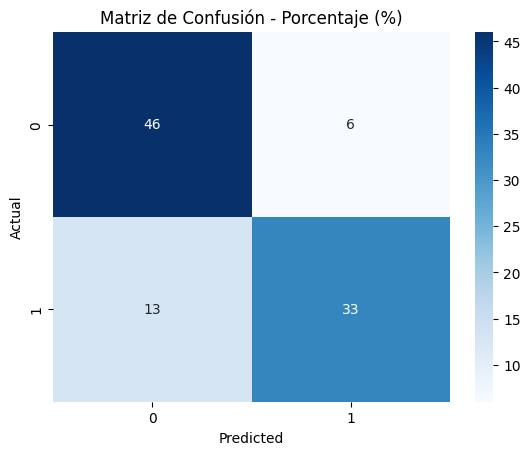

In [13]:
from sklearn.metrics import classification_report


cm2 = confusion_matrix(test_data["num_discreta"], y_pred_test2)



print("Matriz de confusión del modelo de prueba:")
print(cm2)

print("Indicadores Generales")
report2 = classification_report(test_data["num_discreta"], y_pred_test2)
print(report2)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm_test2 = cm2
sumat2 = 0
for i in cm2 :
    sumat2 += sum(i)

for i in range(len(cm_test2)):
    for j in range(len(cm_test2[1])):
        cm_test2[i,j]=(cm2[i,j]/sumat2*100)

# Crear el mapa de calor utilizando Seaborn
sns.heatmap(cm_test2, annot=True, cmap='Blues', fmt='')


# Personalizar la figura
plt.title('Matriz de Confusión - Porcentaje (%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

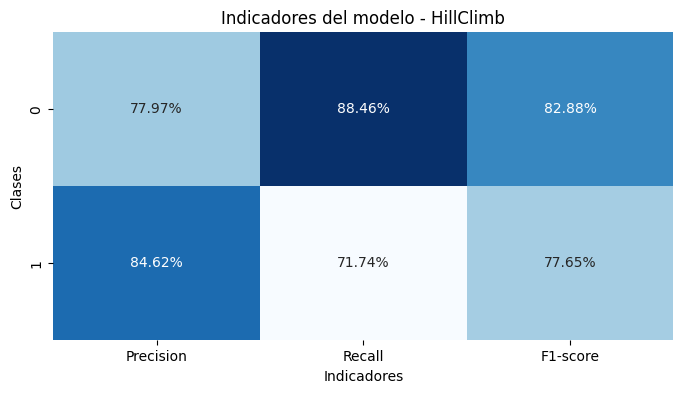

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score



# Calcular los valores de precisión, recall y f1-score
precision2 = np.diag(cm2) / np.sum(cm2, axis=0)
recall2 = np.diag(cm2) / np.sum(cm2, axis=1)
f1_2 = 2 * precision2 * recall2 / (precision2 + recall2)

# Crear un dataframe con los valores de los indicadores
df_indicadores2 = pd.DataFrame({'Precision': precision2, 'Recall': recall2, 'F1-score': f1_2})

# Crear la figura y el mapa de calor
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(df_indicadores2, annot=True, cmap='Blues', cbar=False, fmt='.2%')

# Añadir títulos y etiquetas
ax.set_title('Indicadores del modelo - Otro Grupo')
ax.set_xlabel('Indicadores')
ax.set_ylabel('Clases')

# Mostrar la figura
plt.show()